# Kaggle Competition | Titanic Machine Learning from Disaster

> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
>
> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
>
> In this contest, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.
>
> This Kaggle Getting Started Competition provides an ideal starting place for people who may not have a lot of experience in data science and machine learning."

From the competition [homepage](https://www.kaggle.com/c/titanic).

## This notebook

The aim of this notebook is to give you some insight into a more "real" world problem where are data isn't cleaned for us. We need to explore the data, clean it and then apply some ML methods.

First we'll need to install some dependencies and then import them.

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import datasets, svm
from statsmodels.nonparametric import smoothers_lowess
from statsmodels.nonparametric.kde import KDEUnivariate

In [34]:
%matplotlib inline

## The data

First let's read in a data and see what we're dealing with.

In [41]:
df = pd.read_csv("data/train.csv") 
print(fr"{df.shape[0]} rows, {df.shape[1]} columns")
df.head()

891 rows, 12 columns


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [59]:
f"The survived column is a boolean with values: {set(df['Survived'].unique())}"

'The survived column is a boolean with values: {0, 1}'

In [62]:
f"The Pclass column represents the class of the ticket with values: {set(df['Pclass'].unique())}"

'The Pclass column represents the class of the ticket with values: {1, 2, 3}'

In [66]:
f"The SidSp column takes values: {set(df['SibSp'].unique())}"

'The SidSp column takes values: {0, 1, 2, 3, 4, 5, 8}'

In [69]:
f"The Parch column takes values: {set(df['Parch'].unique())}"

'The Parch column takes values: {0, 1, 2, 3, 4, 5, 6}'

In [71]:
f"The Embarked column takes values: {set(df['Embarked'].dropna().unique())}"

"The Embarked column takes values: {'Q', 'C', 'S'}"

## Missing values

One thing we want to watch out for is how complete our dataset is. First, let's have a look at the number of rows and how many entries are non-null.

In [25]:
percentage_complete = df.notnull().sum() / df.shape[0]
percentage_complete.map("{:.1%}".format)

PassengerId    100.0%
Survived       100.0%
Pclass         100.0%
Name           100.0%
Sex            100.0%
Age             80.1%
SibSp          100.0%
Parch          100.0%
Ticket         100.0%
Fare           100.0%
Cabin           22.9%
Embarked        99.8%
dtype: object

Clearly we can see that _Cabin_ in particular has a significant number of entries missing. How can we deal with that? At this point it's probably worth just removing it from our dataset.

In [26]:
df.drop(["Cabin"], axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S

Now that we're removed _Cabin_ we're safe to drop all remaining NaN values. If we'd ran this line first our dataset would have been ~23% of it's original size!

In [28]:
df.dropna(inplace=True)
df.shape

(712, 11)

## Exploring the data visually

In [72]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location");

## Can we predict if a passenger will survive?

We can use features such as:
* Travelling class
* Sex
* Age
* Fare

Let's see if we can get a better understanding of who did and who didn't survive.

<Figure size 432x288 with 0 Axes>

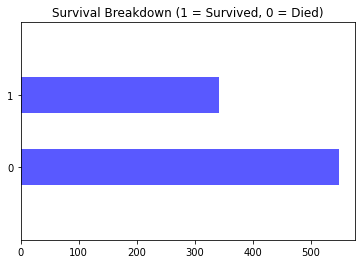

In [81]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.Survived.value_counts()))
plt.title("Survival Breakdown (1 = Survived, 0 = Died)");

## Breaking down the survival rate by gender

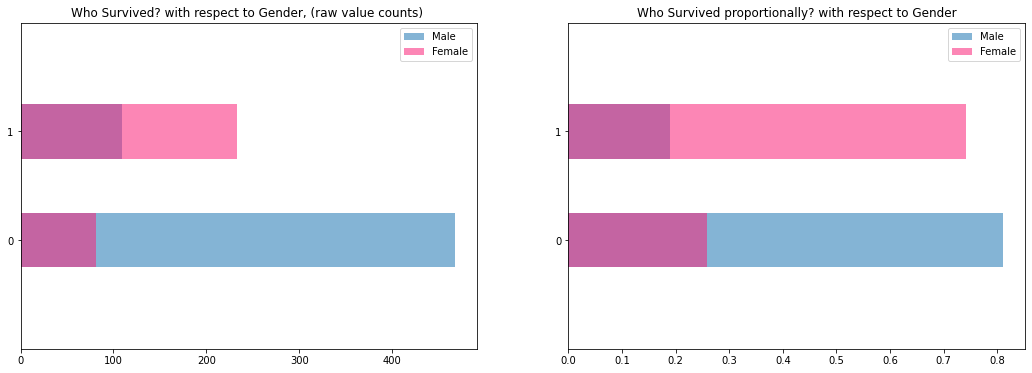

In [83]:
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2);

This shows that although more men survived in raw value count, as a propotion of the original passengers more women survived.

## What about the travelling class?

Here we will split classes into the lowest (3) and the higher ones (2 or 1). We can break it down further by gender.

In [87]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best');

Now we gradually building a better picture of the data and we can gain insight into which factors affected the survival rate more.

Now that we know what we're trying to predict let's develop a model.